<a href="https://colab.research.google.com/github/willianrocha/bootcamp-datascience-alura/blob/main/module_3/ds_mod3_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from sklearn.metrics import  mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import median_absolute_error
from pandas.plotting import autocorrelation_plot
from datetime import date, timedelta
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings('ignore')
mpl.rcParams['font.size'] = 12
mpl.rcParams['figure.figsize'] = (15,9)

In [2]:
GRAY1 = '#BFBEBE'
GRAY4 = '#646369'
GRAY5 = '#76787B'
RED1 = '#99322B'
RED2 = '#E66157'
BLUE1 = '#326599'
BLUE2 = '#4092E6'

def to_color(ax, fontsize: int, color: str):
  plt.sca(ax)
  plt.grid(color = 'lightgrey', linewidth = 0.5)
  ax.spines['bottom'].set_color(GRAY5)
  ax.spines['left'].set_color(GRAY5)
  ax.tick_params(color = GRAY5, bottom = 'off')
  for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(12)
    i.set_color(GRAY5)

def suptitle_formatter(suptitle, subtitle=None):
  suptitle_formated = "$\\bf{" + '\ '.join(suptitle.split()) + '}$'
  if subtitle is not None:
     suptitle_formated += '\n' + subtitle
  return suptitle_formated

In [3]:
casos_brasil_io = 'https://github.com/willianrocha/bootcamp-datascience-alura/raw/main/files/caso_full.csv.gz'
dtype_category = {
    'city' : 'object',
    'city_ibge_code' :  'float32',
    'date' : str,
    'epidemiological_week' : 'int32',
    'estimated_population': 'float32',
    'is_last': 'bool',
    'is_repeated': 'bool',
    'last_available_confirmed' : 'int16',
    'last_available_confirmed_per_100k_inhabitants' : 'float32',
    'last_available_date' : str,
    'last_available_death_rate' : 'float32',
    'last_available_deaths' : 'int16',
    'order_for_place' : 'int16',
    'place_type' : 'category',
    'state' : 'category',
    'new_confirmed' : 'int16',
    'new_deaths' : 'int16'
    }
dados = pd.read_csv(casos_brasil_io, compression='gzip',
                    dtype=dtype_category,
                    parse_dates=[2, 9]
                    )
dados.head()

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,Rio Branco,1200401.0,2020-03-17,202012,413418.0,407319.0,False,False,3,0.7256600260734558,2020-03-17,0.0,0,1,city,AC,3,0
1,NaN,12.0,2020-03-17,202012,894470.0,881935.0,False,False,3,0.33539000153541565,2020-03-17,0.0,0,1,state,AC,3,0
2,Rio Branco,1200401.0,2020-03-18,202012,413418.0,407319.0,False,False,3,0.7256600260734558,2020-03-18,0.0,0,2,city,AC,0,0
3,NaN,12.0,2020-03-18,202012,894470.0,881935.0,False,False,3,0.33539000153541565,2020-03-18,0.0,0,2,state,AC,0,0
4,Rio Branco,1200401.0,2020-03-19,202012,413418.0,407319.0,False,False,4,0.9675400257110596,2020-03-19,0.0,0,3,city,AC,1,0


# Avaliação do estado do Pará vs Região Metropolitana de Belém vs Intetior do Pará

Vamos avaliar os casos diários do estado do Pará, os casos na Região metropolitana e no interior do estado. Para isso, vamos calcular a média móvel destes 3 conjuntos. Dada a má infraestrutura de saúde histórica do estado do Pará, podemos esperar uma grande variação dos casos dia a dia. Essa variação pode ser causada por atrasos na notificação, demora no atendimento ou falta de testes.

## Estado do Pará

Calculando a média móvel para o estado do Pará inteiro. A base de dados lista os valores por cidade e os agrupa por estado.

In [4]:
dados_pa = dados.query("state == 'PA' and place_type == 'state'")
dados_pa['rolling_new_cases'] = dados_pa['new_confirmed'].rolling(window=7, center=False).mean()
dados_pa['rolling_new_deaths'] = dados_pa['new_deaths'].rolling(window=7, center=False).mean()

dados_pa_cases_melt = dados_pa[['date', 'new_confirmed', 'rolling_new_cases']]
dados_pa_cases_melt.columns = ['Data', 'Novos Casos', 'Média móvel']
dados_pa_cases_melt = dados_pa_cases_melt.melt(id_vars=['Data'], value_vars=['Novos Casos', 'Média móvel'], value_name='Casos')

## Região Metropolitana de Belém



In [110]:
municipios_rmb = ['Belém', 'Ananindeua', 'Benevides', 'Castanhal', 'Marituba',
                  'Santa Bárbara do Pará', 'Santa Izabel do Pará']
dados_pa_rmb = dados.query("state == 'PA' and place_type == 'city' and city in @municipios_rmb").reset_index(drop=True)
dados_pa_rmb.drop(inplace=True, axis=1, columns=['city_ibge_code', 'is_last', 'is_repeated', 'last_available_date', 'place_type', 'state', 'epidemiological_week'])
dados_pa_rmb_pivoted = dados_pa_rmb.pivot(index=['date'], columns='city')
media_movel_rmb = dados_pa_rmb_pivoted['new_confirmed'].rolling(window=7, center=False).mean().reset_index().melt(id_vars=['date'], value_vars=municipios_rmb, value_name='rolling')
dados_pa_rmb = pd.merge(left=dados_pa_rmb, right=media_movel_rmb, on=['date', 'city'], how='left')
dados_pa_rmb['cases_prop'] = 100000 * dados_pa_rmb['rolling'] / dados_pa_rmb['estimated_population']

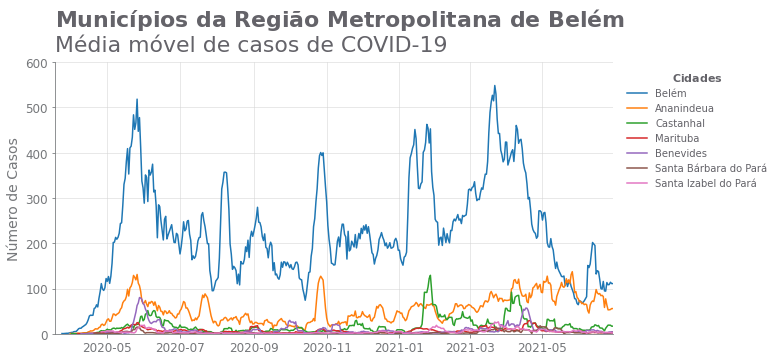

In [108]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
sns.lineplot(data=dados_pa_rmb, x='date', y='rolling', hue='city')
sns.despine()
plt.grid(color = 'lightgrey', linewidth = 0.5)
to_color(ax, 10, GRAY5)
ax.set_ylabel('Número de Casos', fontsize = 14, color = GRAY5)
ax.set_xlabel('')
ax.set_xlim(dados_pa_rmb['date'].min()+timedelta(days=0), dados_pa_rmb['date'].max())
ax.set_ylim(0, 600)
leg = plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left', title='$\\bf{Cidades}$', title_fontsize=11, frameon=False)
for text in leg.get_texts():
    plt.setp(text, color = GRAY4)
plt.setp(leg.get_title(), color=GRAY4)
subtitle = 'Média móvel de casos de COVID-19'
suptitle = 'Municípios da Região Metropolitana de Belém'
plt.suptitle(suptitle_formatter(suptitle, subtitle), fontsize = 22, color = GRAY4, y=fig.subplotpars.top+0.155, x=fig.subplotpars.left, ha='left')
plt.show()

Como experado, Belém é o municipio com maior número de casos por ser o mais populoso. Uma melhor avaliação é pode ser olhando os casos em relação a população do municipio.

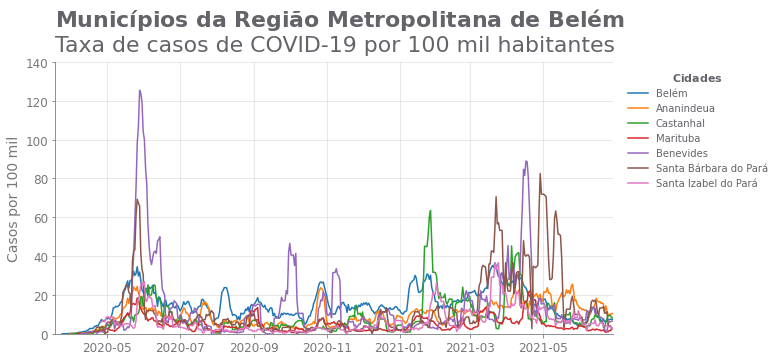

In [114]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
sns.lineplot(data=dados_pa_rmb, x='date', y='cases_prop', hue='city')
sns.despine()
plt.grid(color = 'lightgrey', linewidth = 0.5)
to_color(ax, 10, GRAY5)
ax.set_ylabel('Casos por 100 mil', fontsize = 14, color = GRAY5)
ax.set_xlabel('')
ax.set_xlim(dados_pa_rmb['date'].min()+timedelta(days=0), dados_pa_rmb['date'].max())
ax.set_ylim(0, 140)
leg = plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left', title='$\\bf{Cidades}$', title_fontsize=11, frameon=False)
for text in leg.get_texts():
    plt.setp(text, color = GRAY4)
plt.setp(leg.get_title(), color=GRAY4)
subtitle = 'Taxa de casos de COVID-19 por 100 mil habitantes'
suptitle = 'Municípios da Região Metropolitana de Belém'
plt.suptitle(suptitle_formatter(suptitle, subtitle), fontsize = 22, color = GRAY4, y=fig.subplotpars.top+0.155, x=fig.subplotpars.left, ha='left')
plt.show()

Podemos notar que embora Belém tenha a maior população, municipios como Benevides e Santa Bárbara do Pará apresentam uma maior taxa de contágio. Dada a integração da RMB, as avaliações a seguir serão feitas considerando toda a RMB.

In [6]:
dados_pa_rmb_rolling_cases = dados_pa_rmb.groupby('date')[['new_confirmed', 'new_deaths']].sum()
dados_pa_rmb_rolling_cases['rolling_new_cases'] = dados_pa_rmb_rolling_cases['new_confirmed'].rolling(window=7, center=False).mean()
dados_pa_rmb_rolling_cases['rolling_new_deaths'] = dados_pa_rmb_rolling_cases['new_deaths'].rolling(window=7, center=False).mean()
dados_pa_rmb_rolling_cases = dados_pa_rmb_rolling_cases.reset_index()

dados_pa_rmb_rolling_cases_melt = dados_pa_rmb_rolling_cases[['date', 'new_confirmed', 'rolling_new_cases']]
dados_pa_rmb_rolling_cases_melt.columns = ['Data', 'Novos Casos', 'Média móvel']
dados_pa_rmb_rolling_cases_melt = dados_pa_rmb_rolling_cases_melt.melt(id_vars=['Data'], value_vars=['Novos Casos', 'Média móvel'], value_name='Casos')

## Interior do Estado


Embora haja diversos núcleos e interações no interior do estado do Pará, a avaliação deste nível vai além do escopo deste trabalho. Portanto, os estados do interior do Pará serão agrupados.

In [7]:
dados_pa_cs = dados.query("state == 'PA' and place_type == 'city' and city not in @municipios_rmb").reset_index(drop=True)
municipios_cs = set(dados_pa_cs.city.unique().tolist()) - set(municipios_rmb)
dados_pa_cs.drop(inplace=True, axis=1, columns=['city_ibge_code', 'is_last', 'is_repeated', 'last_available_date', 'place_type', 'state', 'epidemiological_week'])
dados_pa_cs_pivoted = dados_pa_cs.pivot(index=['date'], columns='city')
media_movel_cs = dados_pa_cs_pivoted['new_confirmed'].rolling(window=7, center=False).mean().reset_index().melt(id_vars=['date'], value_vars=municipios_cs, value_name='rolling')
dados_pa_cs = pd.merge(left=dados_pa_cs, right=media_movel_cs, on=['date', 'city'], how='left')
dados_pa_cs_rolling_cases = dados_pa_cs.groupby('date')[['new_confirmed', 'new_deaths']].sum()
dados_pa_cs_rolling_cases['rolling_new_cases'] = dados_pa_cs_rolling_cases['new_confirmed'].rolling(window=7, center=False).mean()
dados_pa_cs_rolling_cases['rolling_new_deaths'] = dados_pa_cs_rolling_cases['new_deaths'].rolling(window=7, center=False).mean()
dados_pa_cs_rolling_cases = dados_pa_cs_rolling_cases.reset_index()

dados_pa_cs_rolling_cases_melt = dados_pa_cs_rolling_cases[['date', 'new_confirmed', 'rolling_new_cases']]
dados_pa_cs_rolling_cases_melt.columns = ['Data', 'Novos Casos', 'Média móvel']
dados_pa_cs_rolling_cases_melt = dados_pa_cs_rolling_cases_melt.melt(id_vars=['Data'], value_vars=['Novos Casos', 'Média móvel'], value_name='Casos')

Calculando a média móvel dos óbtios também.

In [8]:
# Média móvel dos óbitos
dados_pa_deaths_melt = dados_pa[['date', 'new_deaths', 'rolling_new_deaths']]
dados_pa_deaths_melt.columns = ['Data', 'Novos Óbitos', 'Média móvel']
dados_pa_deaths_melt = dados_pa_deaths_melt.melt(id_vars=['Data'], value_vars=['Novos Óbitos', 'Média móvel'], value_name='Óbitos')

dados_pa_rmb_rolling_death_melt = dados_pa_rmb_rolling_cases[['date', 'new_deaths', 'rolling_new_deaths']]
dados_pa_rmb_rolling_death_melt.columns = ['Data', 'Novos Óbitos', 'Média móvel']
dados_pa_rmb_rolling_death_melt = dados_pa_rmb_rolling_death_melt.melt(id_vars=['Data'], value_vars=['Novos Óbitos', 'Média móvel'], value_name='Óbitos')

dados_pa_cs_rolling_death_melt = dados_pa_cs_rolling_cases[['date', 'new_deaths', 'rolling_new_deaths']]
dados_pa_cs_rolling_death_melt.columns = ['Data', 'Novos Óbitos', 'Média móvel']
dados_pa_cs_rolling_death_melt = dados_pa_cs_rolling_death_melt.melt(id_vars=['Data'], value_vars=['Novos Óbitos', 'Média móvel'], value_name='Óbitos')

## População por grupo

Antes de prosseguir, vamos avaliar a população de cada grupo.

In [135]:
c, d = dados_pa_cs.groupby(['city']).sum()[['new_confirmed', 'new_deaths']].sum()
c

405649.0

In [139]:
# dados_pa_cs.unique(['city', 'estimated_population'])
pop_cs =   dados_pa_cs.groupby(['city', 'estimated_population']).size().reset_index().sum()['estimated_population']
cs_cases, cs_deaths = dados_pa_cs.groupby(['city']).sum()[['new_confirmed', 'new_deaths']].sum()

pop_rmb = dados_pa_rmb.groupby(['city', 'estimated_population']).size().reset_index().sum()['estimated_population']
rmb_cases, rmb_deaths = dados_pa_rmb.groupby(['city']).sum()[['new_confirmed', 'new_deaths']].sum()

data = {'Região': ['Estado do Pará', 'RMB', 'Interior do Estado'],
        'População': [int(pop_cs+pop_rmb), int(pop_rmb), int(pop_cs)],
        # 'Proporção Pop': ['100%', str(100*pop_rmb/(pop_cs+pop_rmb))+"%", str(100*pop_cs/(pop_cs+pop_rmb))+"%"],
        'Casos': [int(cs_cases+rmb_cases), int(rmb_cases), int(cs_cases)],
        'Óbitos': [int(cs_deaths+rmb_deaths), int(rmb_deaths), int(cs_deaths)]}
df2 = pd.DataFrame(data)
df2

,Região,População,Casos,Óbitos
0,Estado do Pará,8690745,551140,15444
1,RMB,2529178,145491,6500
2,Interior do Estado,6161567,405649,8944


A RMB contempla 30% da população em relação a população do estado.

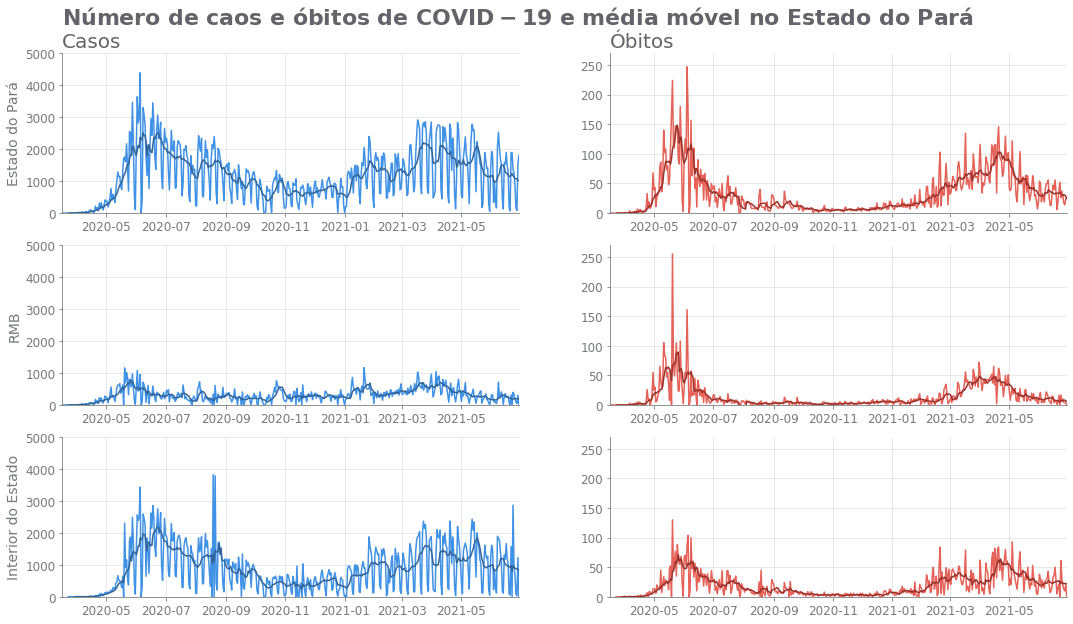

In [9]:
def uniform_plots(ax, y_label, df, y_axis, colors):
  sns.lineplot(data=df, x='Data', y=y_axis, hue='variable', ax=ax, palette=colors)
  ax.get_legend().remove()
  to_color(ax, 10, GRAY5)
  ax.set_xlabel('')
  ax.set_xlim(dados['date'].min()+timedelta(days=21), dados['date'].max())
  if y_axis == 'Casos':
    ax.set_ylabel(y_label, fontsize = 14, color = GRAY5)
    ax.set_ylim(0, 5000)
  else:
    ax.set_ylim(0, 270)
    ax.set_ylabel('')

fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32)) = plt.subplots(nrows=3, ncols=2, figsize=(18,10))
y_label = ['Estado do Pará', 'Estado do Pará', 'RMB', 'RMB', 'Interior do Estado', 'Interior do Estado']
df_estado = [dados_pa_cases_melt, dados_pa_deaths_melt,
             dados_pa_rmb_rolling_cases_melt, dados_pa_rmb_rolling_death_melt,
             dados_pa_cs_rolling_cases_melt, dados_pa_cs_rolling_death_melt]
eixos = [ax11, ax12, ax21, ax22, ax31, ax32]
for i, ax in enumerate(eixos):
  if i % 2:
    y_axis = 'Óbitos'
    colors = [RED2, RED1]
  else:
    y_axis = 'Casos'
    colors = [BLUE2, BLUE1]
  uniform_plots(ax, y_label[i], df_estado[i], y_axis, colors)
sns.despine()

suptitle = 'Número de caos e óbitos de COVID-19 e média móvel no Estado do Pará'
# suptitle_formated = "$\\bf{" + '\ '.join(suptitle.split()) + '}$'
plt.suptitle(suptitle_formatter(suptitle), fontsize = 22, color = GRAY4, y=fig.subplotpars.top+0.065, x=fig.subplotpars.left, ha='left')
ax11.set_title('Casos', fontsize = 20, color = GRAY4, loc='left')
ax12.set_title('Óbitos', fontsize = 20, color = GRAY4, loc='left')

plt.show()

Em relação a quantidade de casos, a distruibuição de casos segue porporcional. Porém ao observar os óbitos, vemos que o número de óbitos
Aqui, temos dados conflitantes. Embora a população da RMB seja responsável por 30% da população, a porcentagem de mortos no estado do Pará é de 40%.

Essa discrepância de proporções se dá pela falta de infra estrutura no interior do estado, então os casos mais graves acabam sendo levados a capital ou principais cidades do estado.

## Correlação entre óbitos e casos na RMB

Dada a melhor consistência dos dados da RMB, vamos focar neste grupo.

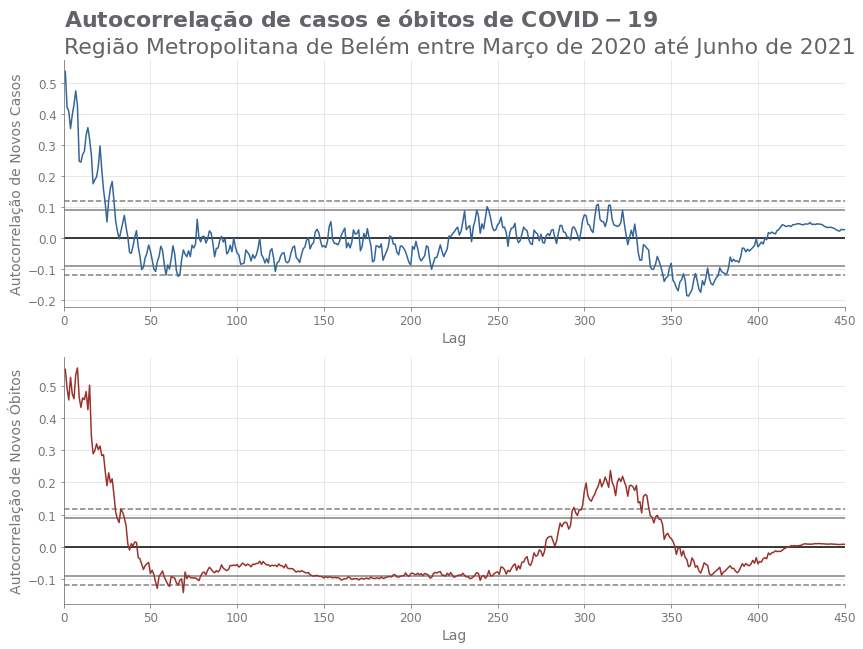

In [71]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,10))
autocorrelation_plot(dados_pa_rmb_rolling_cases['new_confirmed'], ax1, color=BLUE1)
autocorrelation_plot(dados_pa_rmb_rolling_cases['new_deaths'], ax2, color=RED1)

for ax in [ax1, ax2]:
  plt.sca(ax)
  plt.grid(color = 'lightgrey', linewidth = 0.5)
  to_color(ax, 10, GRAY5)
  ax.set_xlabel("Lag", fontsize = 14, color = GRAY5)
  ax.set_xlim(0, 450)

sns.despine()
ax1.set_ylabel("Autocorrelação de Novos Casos", fontsize = 14, color = GRAY5)
ax2.set_ylabel("Autocorrelação de Novos Óbitos", fontsize = 14, color = GRAY5)
suptitle = 'Autocorrelação de casos e óbitos de COVID-19'
subtitle = 'Região Metropolitana de Belém entre Março de 2020 até Junho de 2021'
plt.suptitle(suptitle_formatter(suptitle, subtitle), fontsize = 22, color = GRAY4, y=fig.subplotpars.top+0.075, x=fig.subplotpars.left, ha='left')
plt.show()

A autocorrelação dos dados acima mostra que quaisquer medidas tomadas para controle da COVID-19 levam 2 semanas para tomarem efeitos. Outro ponto que podemos salientar é o recrudescimento apatir de 30 dias dos óbitos, em Março de 2021, que é a segunda onda. 

## Previsão temporal

Vamos realizar a previsão temporal do número de casos da RMB.

### Modelo inicial não refinado

In [163]:
dias = 30
forecast = 60
cut = len(dados_pa_rmb_rolling_cases['date'].unique()) - forecast# dados_pa_rmb_rolling_cases.query("date == '2021-01-01'").index.tolist()[0] + dias  # Até 2021
x='date'
y='new_confirmed'
xlabel='Data'
ylabel='Casos novos'
df = pd.DataFrame()
df['ds'] = dados_pa_rmb_rolling_cases[x][:cut]
df['y'] = dados_pa_rmb_rolling_cases[y][:cut]
df_teste = pd.DataFrame()
df_teste['ds'] = dados_pa_rmb_rolling_cases[x][cut:]
df_teste['y'] = dados_pa_rmb_rolling_cases[y][cut:]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


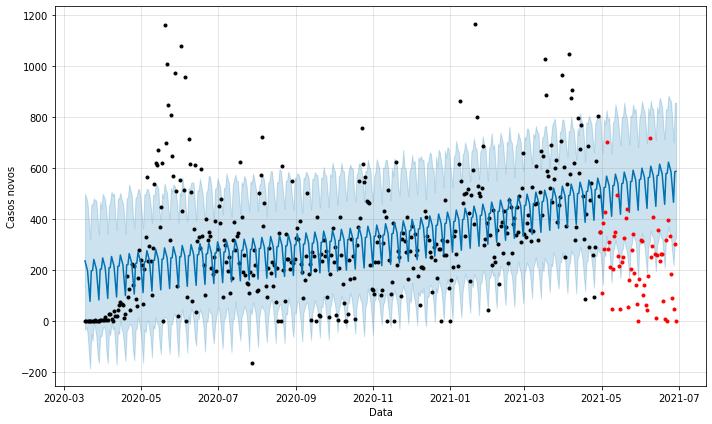

In [140]:
modelo_inicial = Prophet()
modelo_inicial.fit(df)
dataframefuturo_inicial = modelo_inicial.make_future_dataframe(periods=forecast)
previsao_inicial = modelo_inicial.predict(dataframefuturo_inicial)
fig = modelo_inicial.plot(previsao_inicial, xlabel=xlabel, ylabel=ylabel, figsize=(10,6))
plt.plot(df_teste['ds'], df_teste['y'], '.r')
plt.show()

Dado o gráfico acima, podemos ver que o modelo não consegue prever o decaimento de casos. Antes de refirnar o modelo, vamos avalair o modelo incial.

In [13]:
def evaluation_model(y, y_hat):
  mse = mean_squared_error(y, y_hat)
  r2 = r2_score(y, y_hat)
  mae = median_absolute_error(y, y_hat)
  return {'MSE': mse, 'R2': r2, 'MAE': mae}

Para avaliação, vamos utulizar o Mean Squered Error, Median Absolute Error e R2. Para R2, quanto mais próximo de 1 melhor, e quanto menor o valor de MSE e MAE melhor.

In [14]:
evaluation_initial = evaluation_model(df['y'], previsao_inicial['yhat'][:cut])
evaluation_initial

{'MAE': 113.75520014064824,
 'MSE': 40823.67669031842,
 'R2': 0.22455105162356603}

Inicialmente, o MAE e MSE não são muito significativos pois não há uma comparação objetiva. Porém, o R2 já nos conta que esse modelo está bem impreciso.

### Modelo considerando feriados e e refinamentos.

Adicionando os feriados de 2020 e 2021

In [15]:
feriados_belem = ['2020-04-09', '2020-04-10', '2020-04-21', '2020-05-01',
                  '2020-06-11', '2020-06-12', '2020-08-15', '2020-09-07',
                  '2020-10-12', '2020-10-26', '2020-10-30', '2020-11-02',
                  '2020-11-15', '2020-12-08', '2020-12-25', '2021-01-01',
                  '2021-02-15', '2021-02-16', '2021-02-17', '2021-04-01',
                  '2021-04-02', '2021-04-21', '2021-05-01', '2021-06-03',
                  '2021-06-04']
feriados = pd.DataFrame({
    'holiday' : 'pa_2021',
    'ds' : pd.to_datetime(feriados_belem)
})

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


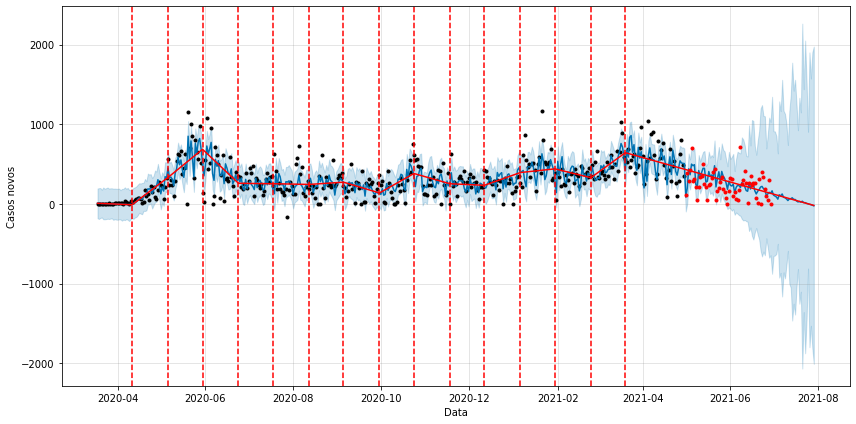

{'MAE': 86.81196598580004, 'MSE': 21799.475303963554, 'R2': 0.5859172526803409}

In [173]:
modelo_feriados_ref = Prophet(holidays=feriados, n_changepoints=15 ,changepoint_prior_scale=35, changepoint_range=0.9, seasonality_mode='multiplicative')
modelo_feriados_ref.add_seasonality(name='monthly', period=30.5, fourier_order=20, prior_scale=20)
modelo_feriados_ref.fit(df)
dataframefuturo_feriados_ref = modelo_feriados_ref.make_future_dataframe(periods=90)
previsao_feriados_ref = modelo_feriados_ref.predict(dataframefuturo_feriados_ref)

fig = modelo_feriados_ref.plot(previsao_feriados_ref, xlabel=xlabel, ylabel=ylabel, figsize=(12,6), )
plt.plot(df_teste['ds'], df_teste['y'], '.r')
add_changepoints_to_plot(fig.gca(), modelo_feriados_ref, previsao_feriados_ref)
plt.show()

evaluation_refined = evaluation_model(df['y'], previsao_feriados_ref['yhat'][:cut])
evaluation_refined

Graficamente, podemos ver que a linha de tendencia se ajustou melhor ao pontos, e a região de confiança agrupa melhor os dados de teste. Este modelo aponta que em 30 dias, não haverá casos de COVID-19 na RMB.

Mas, ainda podemos ver muitos outliers que podem prejudicando o ajuste do modelo e derrubando as métricas.

In [142]:
#modelo_feriados.plot_components(previsao_feriados_ref);

### Removendo outliers

In [ ]:
df_original = df.reset_index()
sem_outliers = df_original[(df_original['y'] > previsao_feriados_ref['yhat_lower'][:cut]) & (df_original['y'] < previsao_feriados_ref['yhat_upper'][:cut])]
df_wo_outlier = sem_outliers[['ds', 'y']]

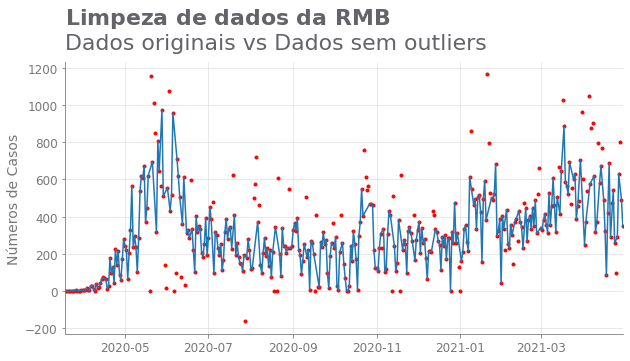

In [161]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
plt.plot(df_original['ds'], df_original['y'], 'r.')
sns.lineplot(data=sem_outliers, x='ds', y='y')
sns.despine()
plt.grid(color = 'lightgrey', linewidth = 0.5)
to_color(ax, 10, GRAY5)
ax.set_ylabel('Números de Casos', fontsize = 14, color = GRAY5)
ax.set_xlabel('')
ax.set_xlim(df_original['ds'].min()+timedelta(days=0), df_original['ds'].max())
# ax.set_ylim(0, 140)
# leg = plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left', title='$\\bf{Cidades}$', title_fontsize=11, frameon=False)
for text in leg.get_texts():
    plt.setp(text, color = GRAY4)
plt.setp(leg.get_title(), color=GRAY4)
subtitle = 'Dados originais vs Dados sem outliers'
suptitle = 'Limpeza de dados da RMB'
plt.suptitle(suptitle_formatter(suptitle, subtitle), fontsize = 22, color = GRAY4, y=fig.subplotpars.top+0.155, x=fig.subplotpars.left, ha='left')
plt.show()

Acima, podemos observar os pontos em vermelho como dados originais e em azul os dados sem outlier.

In [28]:
dias = 30
forecast = 60
cut=df_wo_outlier[df_wo_outlier['ds'] == dados_pa_rmb_rolling_cases['date'].max() - timedelta(days=forecast)].index.values.tolist()[0]
cut_wo_outlier = 338 #previsao_feriados_wo_outlier[previsao_feriados_wo_outlier['ds'] == df_wo_outlier_t['ds'].max()].index.values.tolist()[0]+1
x='date'
y='new_confirmed'
xlabel='Data'
ylabel='Casos novos'
df_wo_outlier_t = pd.DataFrame()
df_wo_outlier_t['ds'] = df_wo_outlier['ds'][:cut]
df_wo_outlier_t['y'] = df_wo_outlier['y'][:cut]
df_teste = pd.DataFrame()
df_teste['ds'] = dados_pa_rmb_rolling_cases[x][cut:]
df_teste['y'] = dados_pa_rmb_rolling_cases[y][cut:]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


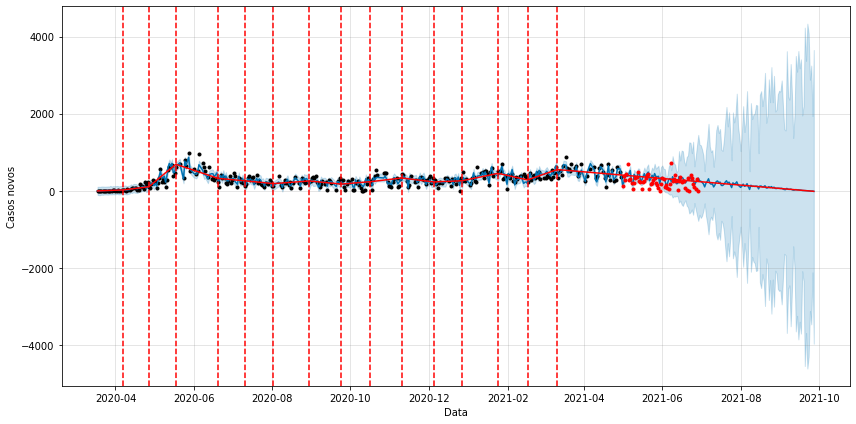

{'MAE': 51.83822787465624, 'MSE': 6766.458528013095, 'R2': 0.8034179529959159}

In [167]:
modelo_feriados_wo_outlier = Prophet(holidays=feriados, n_changepoints=15 ,changepoint_prior_scale=35, changepoint_range=0.9, seasonality_mode='multiplicative')
modelo_feriados_wo_outlier.add_seasonality(name='monthly', period=30.5, fourier_order=20, prior_scale=20)
modelo_feriados_wo_outlier.fit(df_wo_outlier_t)
dataframefuturo_feriados_wo_outlier  = modelo_feriados_wo_outlier.make_future_dataframe(periods=forecast+90)
previsao_feriados_wo_outlier = modelo_feriados_wo_outlier.predict(dataframefuturo_feriados_wo_outlier)

fig = modelo_feriados_wo_outlier.plot(previsao_feriados_wo_outlier, xlabel=xlabel, ylabel=ylabel, figsize=(12,6), )
plt.plot(df_teste['ds'], df_teste['y'], '.r')
add_changepoints_to_plot(fig.gca(), modelo_feriados_wo_outlier, previsao_feriados_wo_outlier)
plt.show()

# evaluation_initial = evaluation_model(df['y'][:cut], previsao_feriados_wo_outlier['yhat'][:cut])
# print(evaluation_initial)
evaluation_refined_wo_outlier = evaluation_model(df_wo_outlier_t['y'], previsao_feriados_wo_outlier['yhat'][:cut_wo_outlier])
evaluation_refined_wo_outlier

Diferente do modelo anterior, este modelo é um pouco mais conservador a aponta para que em 90 dias não haverá mais casos de COVID-19.

Dado o avanço da primeira dose ne RMB, podemos ter uma queda abrupta no número de mortes, porém o de casos continuará mesmo que baixo. Mesmo que a previsão seja otimista, temos que ter cautela até que tenhamos uma boa cobertura vacinal na população total.

# To ignore

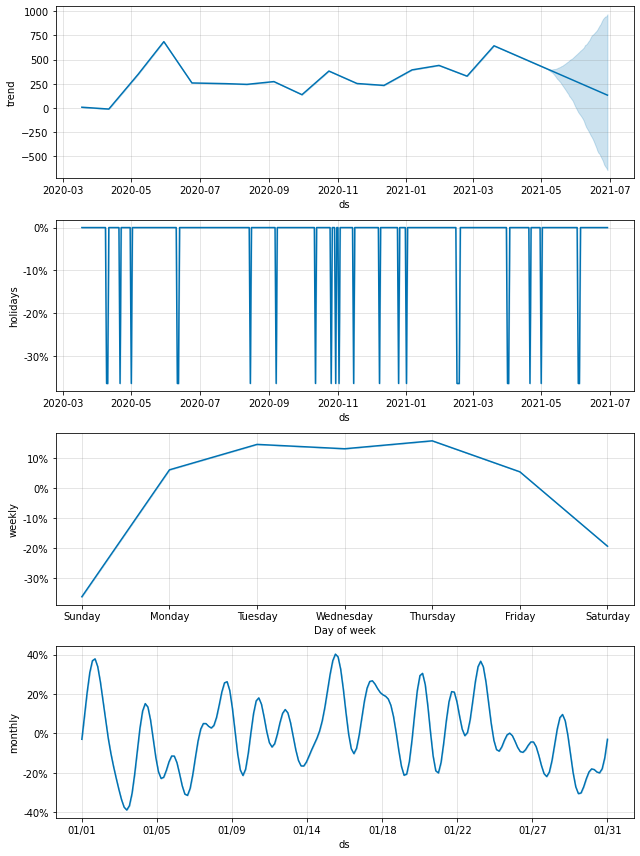

In [168]:
modelo_feriados_wo_outlier.plot_components(previsao_feriados_ref);

In [31]:
df_cv = cross_validation(modelo_feriados, horizon='30 days', initial='180 days', period='30 days')
janela = 5
cutoff = df_cv['cutoff'].unique()[janela]
df_cv_cut = df_cv[df_cv['cutoff'].values == cutoff]
df_cv_cut.head()

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-10-02 00:00:00 and 2021-03-31 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
150,2021-03-02,382.595620,117.194445,636.701549,331,2021-03-01
151,2021-03-03,405.572051,149.539826,661.342833,384,2021-03-01
152,2021-03-04,396.336199,145.570729,647.723066,416,2021-03-01
153,2021-03-05,415.980631,181.588443,666.772725,358,2021-03-01
154,2021-03-06,341.579368,94.235073,591.584776,315,2021-03-01


In [33]:
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,3 days,9461.150011,97.268443,73.417328,0.205494,0.952381
1,4 days,7099.854518,84.260634,64.838482,0.176805,1.000000
2,5 days,22634.512305,150.447706,93.252433,0.161957,0.952381
3,6 days,27639.830175,166.252309,117.611505,0.266593,0.952381
4,7 days,30606.858409,174.948159,120.029096,0.373788,0.904762


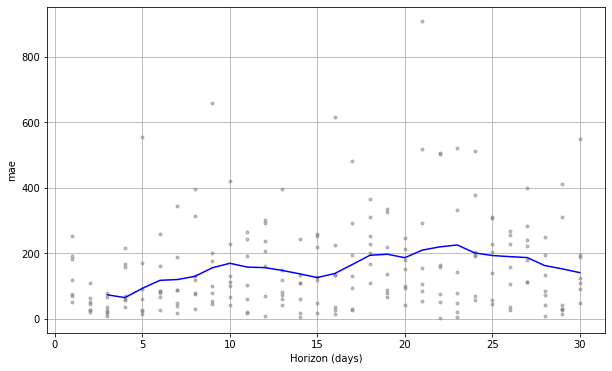

In [34]:
plot_cross_validation_metric(df_cv, metric='mae');

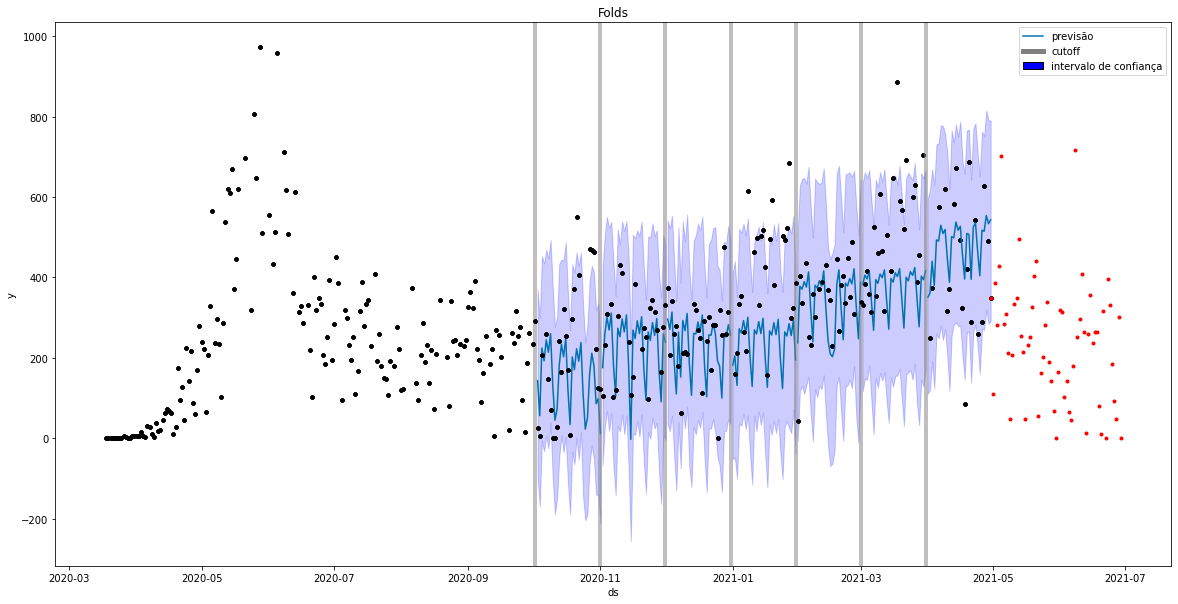

In [38]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
for cutoff in df_cv['cutoff'].unique():
  # cutoff = df_cv['cutoff'].unique()[janela]
  df_cv_cut = df_cv[df_cv['cutoff'].values == cutoff]
  # df_cv_cut.head()
  ax.plot(modelo_feriados_wo_outlier.history['ds'].values, modelo_feriados_wo_outlier.history['y'], 'k.')
  ax.plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', c='#0072B2')
  ax.fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'],
                  df_cv_cut['yhat_upper'], color='blue', alpha=0.2)
  ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
plt.title(f'Folds')
ax.set_ylabel('y')
ax.set_xlabel('ds')
prev = Line2D(range(1), range(1), color="#0072B2", markerfacecolor="red", label="previsão")
ctf = Line2D(range(1), range(1), color="gray", markerfacecolor="red", linewidth=5.0, label="cutoff")
ci = mpatches.Patch(facecolor='blue', edgecolor='k', label="intervalo de confiança")
plt.legend(handles=[prev, ctf, ci])
plt.plot(df_teste['ds'], df_teste['y'], '.r')
plt.show()

In [ ]:
# modelo_feriados = Prophet(holidays=feriados)
# modelo_feriados.fit(df)
# dataframefuturo_feriados = modelo_feriados.make_future_dataframe(periods=60)
# previsao_feriados = modelo_feriados.predict(dataframefuturo_feriados)
# fig = modelo_feriados.plot(previsao_feriados, xlabel=xlabel, ylabel=ylabel, figsize=(10,6), )
# plt.plot(df_teste['ds'], df_teste['y'], '.r')
# add_changepoints_to_plot(fig.gca(), modelo_feriados, previsao_feriados)
# plt.show()

In [ ]:
# evaluation_initial = evaluation_model(df['y'], previsao_feriados['yhat'][:cut])
# evaluation_initial